###  To-Do
- [x] cross-validation
- [x] Visualize the results

#### Cross-validation with less missing features and 250 estimators
- MAE: 17448.4844109589
- Kaggle score: 16373.11794

#### Cross-validation with all the data and 300 estimators
- MAE: 17479.838664383562
- Kaggle score: 16423.34155

In [6]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib

# Visualize the results
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# get the data
X_full = pd.read_csv('train.csv')
X_test_full = pd.read_csv('test.csv')

# remove rows with missing target 
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)

# seperate target from predictors
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace = True)

In [5]:
# remove columns with the most missing data
keep_cols = [col for col in X_full.columns
            if X_full[col].isnull().sum() < 300]
print(keep_cols)

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', '

In [8]:
# Keep columns with the least missing values
X_train = X_full[keep_cols].copy()
X_test = X_test_full[keep_cols].copy()

In [9]:
# seperate numerical and categorical features
numerical_cols = [col for col in X_train.columns
                 if X_train[col].dtype in ['int64', 'float64']]

categorical_cols = [col for col in X_train.columns
                   if X_train[col].dtype == 'object']

In [13]:
# get_score() function
def get_score(n_estimators=100):
    
    # Transformers
    numerical_transformer = SimpleImputer(strategy='median')
    
    categorcal_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessing = ColumnTransformer(transformers=[
        ('numerical', numerical_transformer, numerical_cols),
        ('categorical', categorcal_transformer, categorical_cols)
    ])
    
    # the model
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    
    # bundl the model and preprocessing
    my_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing),
        ('model', model)
    ])
    
    scores = -1 * cross_val_score(my_pipeline, X_train, y, cv = 3,
                                 scoring='neg_mean_absolute_error')
    return scores.mean()

In [14]:
# testing different parameters
n_estimators = [i for i in range(50, 450, 50)]

results = {i: get_score(i) for i in n_estimators}

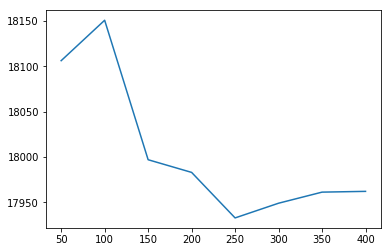

In [16]:
# Visualize the results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results.keys(), results.values())
plt.show()

In [17]:
# Trying the best parameters, using old methods
X_full = X_train
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, test_size=.2,
                                                     random_state=0)

In [18]:
# the pipeline 

# transformers 
numerical_tansformer = SimpleImputer(strategy='median')

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# bundl transformers
preprocessing = ColumnTransformer(transformers=[
    ('numerical', numerical_tansformer, numerical_cols),
    ('categorical', categorical_transformer, categorical_cols)
])

# the model
model = RandomForestRegressor(n_estimators=250, random_state=0)

# bundl preprocessing and model
my_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', model)
])

my_pipeline.fit(X_train, y_train)

preds = my_pipeline.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 17448.4844109589


In [19]:
# Save and generate submission
joblib.dump(my_pipeline, 'Models/rf_250_cv.pkl')

preds_test = my_pipeline.predict(X_test)

sample_submission = pd.read_csv('sample_submission.csv')
output = pd.DataFrame({
    'Id': sample_submission.Id,
    'SalePrice': preds_test
})

output.to_csv('submission.csv', index=False)

## Using columns with the most missing values too

In [4]:
# get categorical and numerical columns for the full dataset
numerical_cols_full = [col for col in X_full.columns 
                      if X_full[col].dtype in ['int64', 'float64']]

categorical_cols_full = [col for col in X_full.columns
                        if X_full[col].dtype == 'object']

In [9]:
# redefine get_score()
def get_score(X, y, n_estimators=100):
    
    # transformers 
    numerical_transformer = SimpleImputer(strategy='median')
    
    categorical_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # bundl transformers
    preprocessing = ColumnTransformer(transformers=[
        ('numerical', numerical_transformer, numerical_cols_full),
        ('categorical', categorical_transformer, categorical_cols_full)
    ])
    
    # the model
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    
    # bundl preprocessing with model
    my_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing),
        ('model', model)
    ])
    
    scores = -1 * cross_val_score(my_pipeline, X, y, cv=3, scoring='neg_mean_absolute_error')
    
    return scores.mean()

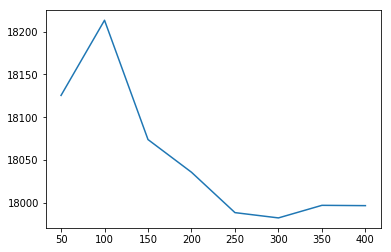

In [10]:
# get scores for the full dataset 
n_esimators = [i for i in range(50, 450, 50)]

scores = {i: get_score(X_full, y, i) for i in n_esimators}

plt.plot(scores.keys(), scores.values())
plt.show()

In [11]:
# Trying the best parameters, using old methods
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, test_size=.2,
                                                     random_state=0)

In [16]:
# the pipeline 

# transformers 
numerical_tansformer = SimpleImputer(strategy='median')

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# bundl transformers
preprocessing = ColumnTransformer(transformers=[
    ('numerical', numerical_tansformer, numerical_cols_full),
    ('categorical', categorical_transformer, categorical_cols_full)
])

# the model
model = RandomForestRegressor(n_estimators=300, random_state=0)

# bundl preprocessing and model
my_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', model)
])

my_pipeline.fit(X_train, y_train)

preds = my_pipeline.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 17479.838664383562


In [18]:
# Save and generate submission
joblib.dump(my_pipeline, 'Models/rf_300_cv_alldata.pkl')

preds_test = my_pipeline.predict(X_test_full)

sample_submission = pd.read_csv('sample_submission.csv')
output = pd.DataFrame({
    'Id': sample_submission.Id,
    'SalePrice': preds_test
})

output.to_csv('submission.csv', index=False)